# M3 paper example

In [1]:
import numpy as np
from qiskit import *
from qiskit_ibm_runtime.fake_provider import FakeGuadalupeV2
import mthree
import matplotlib.pyplot as plt
plt.style.use('quantum-light')

## Setup experiment

In [2]:
backend = FakeGuadalupeV2()
qubits= [1,4,7,10,12,13,14,11,8,5,3,2]

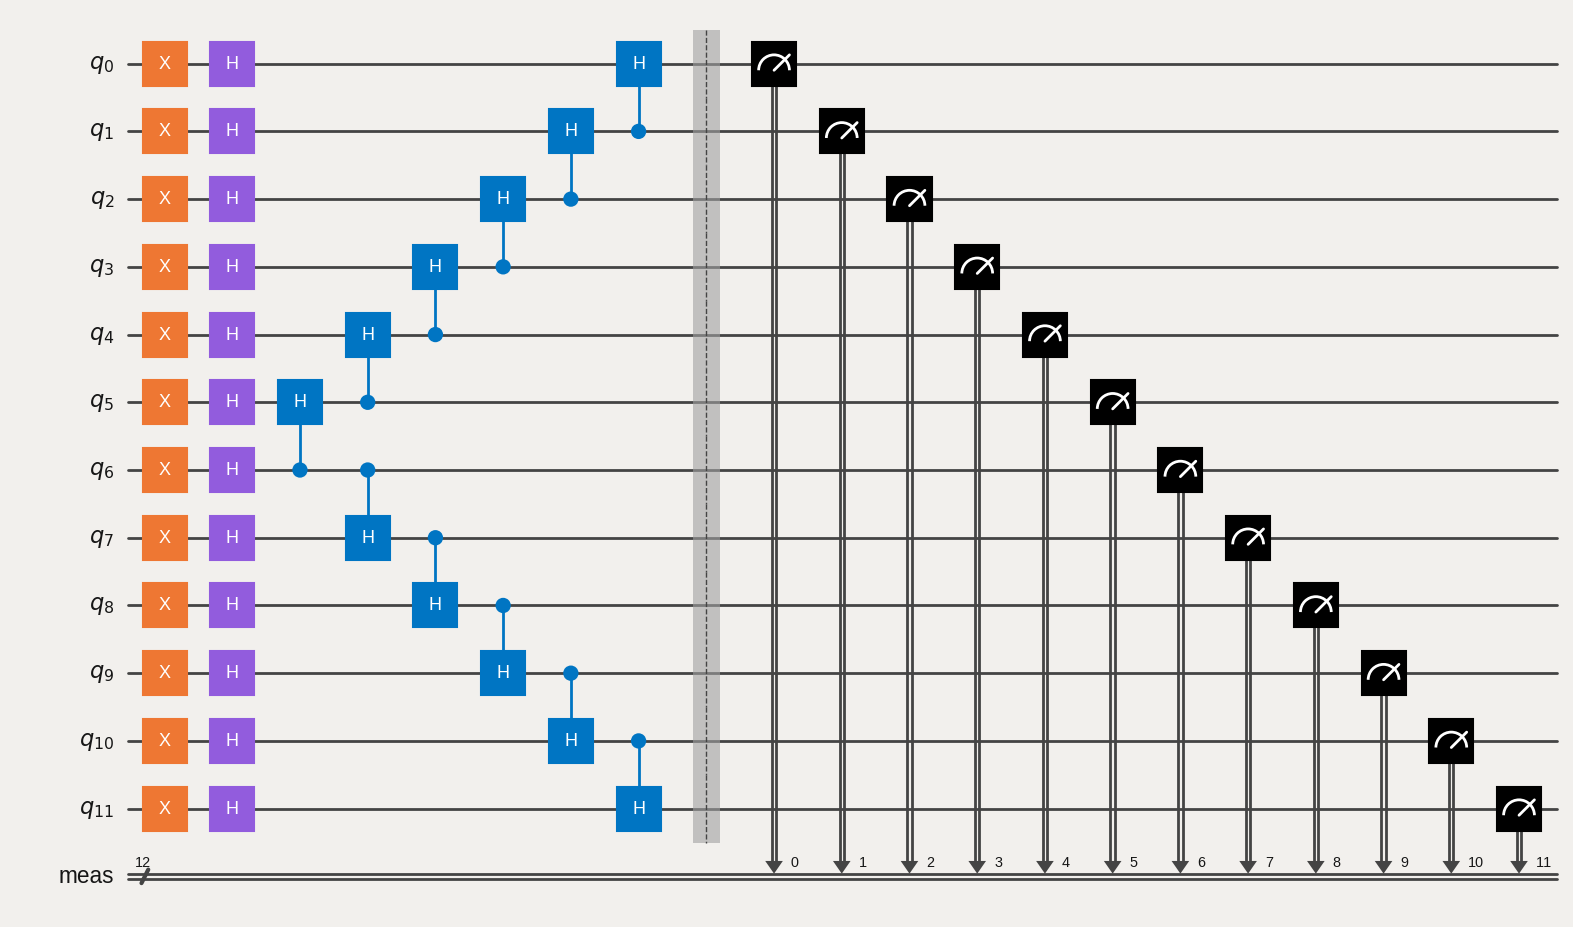

In [3]:
N = 12
qc = QuantumCircuit(N)

qc.x(range(0, N))
qc.h(range(0, N))

for kk in range(N//2,0,-1):
    qc.ch(kk, kk-1)
for kk in range(N//2, N-1):
    qc.ch(kk, kk+1)
qc.measure_all()
qc.draw('mpl')

## Calibrate M3 mitigator, execute circuits, and compute raw and corrected expectation values

In [4]:
mit = mthree.M3Mitigation(backend)
mit.cals_from_system(qubits)

In [5]:
trans_circs = transpile([qc]*10, backend, initial_layout=qubits)
raw_counts = backend.run(trans_circs).result().get_counts()

In [6]:
raw_exp = []
for cnts in raw_counts:
    raw_exp.append(mthree.utils.expval(cnts))

In [7]:
quasis = mit.apply_correction(raw_counts, qubits, return_mitigation_overhead=True)

## Plot results

Here we plot the two distributions of expectation values.  Mitigated is closer to the exact result, $\sim 0.446$, given by the dashed vertical line.

(0.0, 0.5)

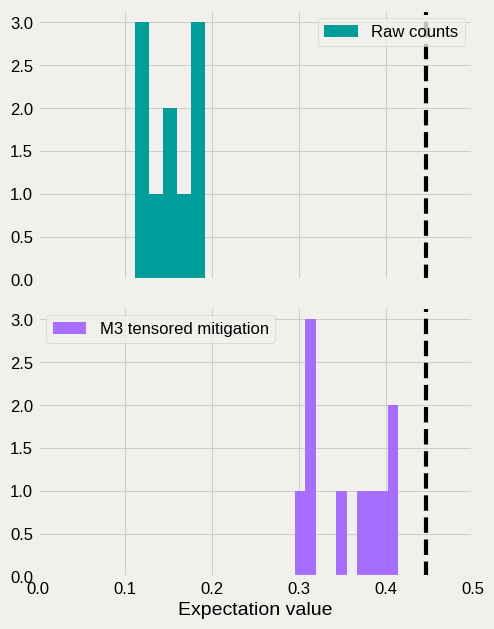

In [8]:
fig = plt.figure(figsize=(5,7))
gs = fig.add_gridspec(2, hspace=0.1)
axs = gs.subplots(sharex=True, sharey=True)
axs[0].hist(raw_exp, bins=5, color='#009d9a')
axs[0].legend(['Raw counts'], fontsize=12)
axs[0].axvline(0.446, color='k', linestyle='--')

axs[1].hist(quasis.expval(), bins=10, color='#a56eff')
axs[1].legend(['M3 tensored mitigation'], fontsize=12)
axs[1].axvline(0.446, color='k', linestyle='--')

axs[1].set_xlabel('Expectation value', fontsize=14)
for ax in axs:
    ax.label_outer()
    ax.tick_params(labelsize=12)
plt.xlim([0,0.5])

## Look at mitigation overhead

The distribution in the above plot is wider for the mitigated expectation values than for the raw results.  This is due to the mitigation overhead that we can extract from the quasi-probabilities

In [9]:
np.mean(quasis.mitigation_overhead)

np.float32(4.685127)

that together with the shots gives us the standard deviation

In [10]:
np.mean(quasis.stddev())

np.float32(0.06763925)